In [39]:
# Load packages to be used. These packages should be installed first.
using PyPlot
using Random
using LinearAlgebra
using Distributions

In [59]:
# Load functions to be used throughout the tutorial.
include("src_spiking_generic/param.jl");
include("src_spiking_generic/lifnet_sim.jl");
include("src_spiking_generic/lifnet_train.jl");
include("src_spiking_generic/genWeights.jl");
include("src_spiking_generic/convertWgtIn2Out.jl")
include("src_spiking_generic/fun.jl");

# 1. Single neuron model

## 1.1. Set up the parameters of single neuron model

Parameters

* $m$: constant input

* $\tau_m$: membrane integration time constant

* thresh: spike threshold

* vre: reset voltage

Variables

* $v$: membrane voltage

* noise: gaussian noise input

* times: spike times

* ns: number of spikes

In [41]:
# parameters
m       = 0.7;
taum    = p.taum
thresh  = p.thresh
vre     = p.vre
# variables
v       = 0;
noise   = 2*randn(p.Nsteps);
# save variables
times   = Float64[];
ns      = 0;
vsave   = zeros(p.Nsteps);

## 1.2. Simulate the neuron activity

\begin{gathered}
    \Large{\tau_m \frac{dv(t)}{dt} = -v(t) + m + u(t)}
\end{gathered}

\begin{gathered}
    \Large{\text{if} \ v(t) = v_{thres} },  \\
    \Large{ \text{spike:} \quad v(t) = \delta(t) } \\
    \Large{ \text{reset:} \quad v(t) = v_{re} }
\end{gathered}

      

Solve the differential equation numerically using Euler method

In [42]:
for ti = 1:p.Nsteps
    t = ti * p.dt
    v += p.dt*((1/taum)*(- v + m + noise[ti]))
    vsave[ti] = v
    #spike occurred
    if v > thresh
        v   = vre
        push!(times,t)
        ns += 1
    end 
end

Plot the membrane voltage

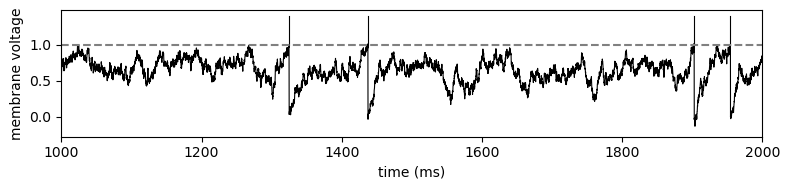

In [43]:
# single neuron's membrane voltage
tvec = p.dt * collect(1:p.Nsteps)
figure(figsize=(8,2))
plot(tvec, vsave, lw=0.8, c="k")
for t = 1:ns
    plot([times[t],times[t]],[1,1.4],c="k", lw=0.8)
end
axhline(1,color="gray",linestyle="--")
xlim([1000,2000])
xlabel("time (ms)")
ylabel("membrane voltage")
tight_layout()
# savefig("figure/neuron_mem.pdf")
PyPlot.display_figs()


# 2. Dynamics of a network of spiking neurons

## 2.1 Network of two neurons

Additional parameters

* $weight = [w_{21}, w_{12}]$:  connection weights

* $IndexOut = [2, 1]$: index of connected neurons

* $\tau_s$: synaptic decay time constant

Additional variables

* $u$: synaptic drive

* forwardInputs: propagated spikes

In [94]:
# parameters
w0IndexOut          = [2, 1]; 
w0Weight            = [5.0, 0.0]; 
taus                = 20.0 
# variables
u                   = zeros(2);
v                   = zeros(2);
noise               = 2*randn(p.Nsteps,2);
# propagated spikes
spikesReceived      = zeros(2);
spikesReceivedPrev  = zeros(2);
# save variables
times               = [Float64[] for ci = 1:2];
ns                  = zeros(Int,2);
vsave               = zeros(p.Nsteps,2);
usave               = zeros(p.Nsteps,2);

In [89]:
# simulate two neuron network
for ti = 1:p.Nsteps
    spikesReceived .= 0.0
    t = ti * p.dt
    for ci = 1:2
        # update synaptic drive
        u[ci] += -dt*u[ci]/taus + spikesReceivedPrev[ci]/taus
        # update membrane voltage
        v[ci] += p.dt*((1/taum)*(- v[ci] + u[ci] + m + noise[ti,ci]))
        # save voltage and synaptic drive
        vsave[ti,ci], usave[ti,ci] = v[ci], u[ci]
        #spike occurred
        if v[ci] > thresh
            v[ci] = vre
            push!(times[ci],t)
            ns[ci] += 1
            # propagate spikes to the other neuron
            cell_receiving_spk = w0IndexOut[ci]
            wgt                = w0Weight[ci]
            spikesReceived[cell_receiving_spk] += wgt
        end #end if(spike occurred)    
    end
    spikesReceivedPrev = copy(spikesReceived)
end

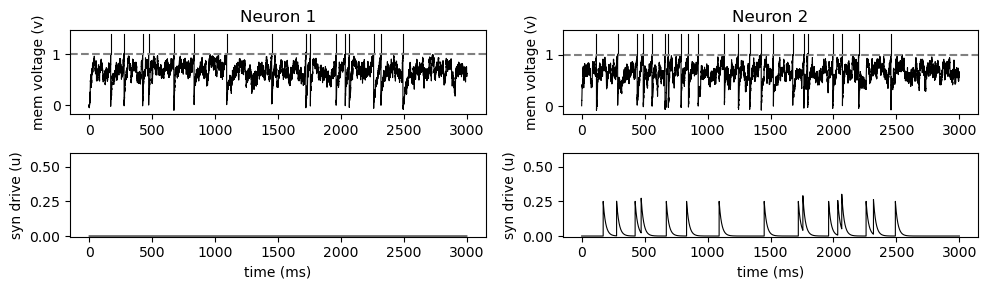

In [90]:
# activity of two neuron network
tvec = p.dt * collect(1:p.Nsteps)
figure(figsize=(10,3))
for ci = 1:2
    subplot(2,2,1 + ci -1)
    plot(tvec, vsave[:,ci], lw=0.8, c="k")
    for t = 1:ns[ci]
        plot([times[ci][t],times[ci][t]],[1,1.4],c="k", lw=0.8)
    end
    axhline(1,color="gray",linestyle="--")
    title("Neuron $(ci)")
    ylabel("mem voltage (v)")

    subplot(2,2,3 + ci -1)
    plot(tvec, usave[:,ci], lw=0.8,c="k")
    xlabel("time (ms)")
    ylabel("syn drive (u)")
    ylim([-0.005, 0.6])
end
# savefig("figure/neuron_mem.pdf")
tight_layout()
PyPlot.display_figs()


## 2.2 Network of $N=100$ neurons

Network connectivity:

* all-to-all connection: all neurons are connected to each other (except to itself)

* random weights: connection wegiths are sampled from a Gaussian distribution $\mathcal{N}(0,\sigma^2)$

Additional parameters

* $IndexOut$: indices of neurons each neuron synapses to

* $weightOut$: weights of connections each neuron synapses to

In [95]:
_, w0WeightOut, _, w0IndexOut, _ = genWeights(p);

Simulate network activity

In [96]:
times, ns, vsave, usave, _ = lifnet_sim(p,w0IndexOut,w0WeightOut);

Plot the membrane voltage and synaptic drive of 5 example neurons

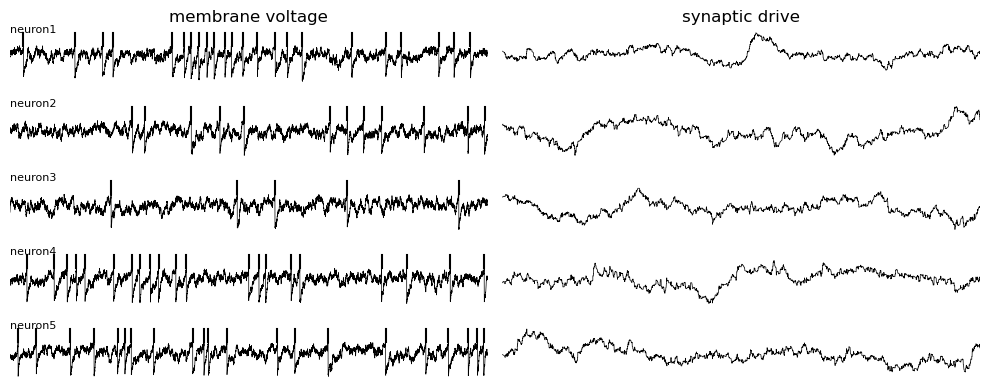

In [100]:
# show voltage and synaptic drive of 5 neurons
tvec = p.dt * collect(1:p.Nsteps)
figure(figsize=(10,4))
for ci = 1:5
    subplot(5,2,2*(ci-1)+1)
    if ci == 1
        title("membrane voltage")
    end
    plot(tvec, vsave[:,ci], lw=0.5,c="k")
    for t = 1:ns[ci]
        plot([times[ci][t],times[ci][t]],[1,1.4],c="k")
    end
    annotate("neuron$(ci)",(1000,1.4), fontsize=8)
    xlim([1000,3000])
    axis("off")
end

for ci = 1:5
    subplot(5,2,2*ci)
    if ci == 1
        title("synaptic drive")
    end
    plot(tvec, usave[:,ci], lw=0.5, c="k")
    xlim([1000,3000])
    axis("off")
end
tight_layout()
# savefig("figure/network_activity.pdf")
PyPlot.display_figs()


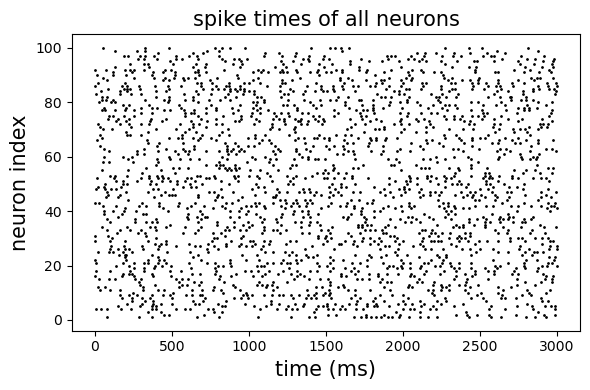

In [101]:
# show spike times of all neurons
figure(figsize=(6,4))
for ci in 1:100
    plt.plot(times[ci][1:ns[ci]],ci*ones(ns[ci]), marker=".", ms=2, color="k", linestyle="")
end
title("spike times of all neurons", fontsize=15)
xlabel("time (ms)", fontsize=15)
ylabel("neuron index", fontsize=15)
tight_layout()
PyPlot.display_figs()


# 3. Learn to generate target activity patterns

Set up network training

* Generate target activity patterns (sine waves with random phases) 

* Generate external cue (called stim)

In [102]:
include("src_spiking_generic/genTarget.jl")
include("src_spiking_generic/genStim.jl")
include("src_spiking_generic/lifnet_train.jl")
w0WeightIn, w0WeightOut, w0IndexIn, w0IndexOut, w0IndexConvert = genWeights(p);
_, _, _, _, uavg = lifnet_sim(p,w0IndexOut,w0WeightOut);
xtarg = genTarget(p,uavg);
stim  = genStim(p);

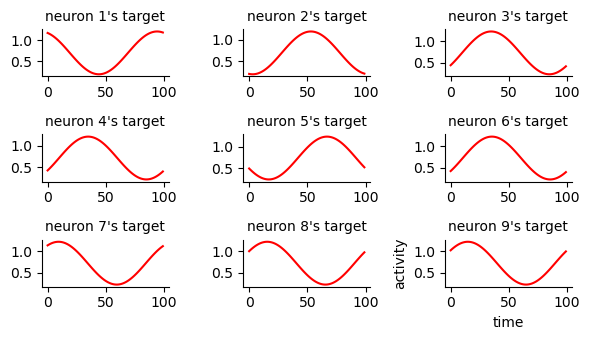

In [103]:
# show target activity patterns
figure(figsize=(6,3.5))
for ci = 1:9
    ax = subplot(3,3,ci)
    plot(xtarg[:,ci], c="r")
    title("neuron $(ci)'s target", fontsize=10)
    ax.spines["right"].set_visible(false)
    ax.spines["top"].set_visible(false)
end
xlabel("time")
ylabel("activity")
tight_layout()
# savefig("figure/target.pdf")
PyPlot.display_figs()

Set up training parameters

* nloop: the number of iterations target patterns are learned

* penlamba: hyperparameter (i.e., penalty) of the weight regularization 

* taus: synaptic decay time constant

    * Large taus (e.g., 200ms) makes learning the target patterns easier

In [104]:
p.nloop     = 20;
p.penlambda = 0.5;
p.taus      = 200.0; # keep it large to make learning easier

Train the network to generate target activity patters

In [105]:
mode = "train"
_, _, _, _ = lifnet_train(mode,p,w0IndexIn,w0IndexOut,w0WeightIn,w0WeightOut,w0IndexConvert,xtarg,stim);

Loop no. 1
Loop no. 2
Loop no. 3
Loop no. 4
Loop no. 5
Loop no. 6
Loop no. 7
Loop no. 8
Loop no. 9
Loop no. 10
Loop no. 11
Loop no. 12
Loop no. 13
Loop no. 14
Loop no. 15
Loop no. 16
Loop no. 17
Loop no. 18
Loop no. 19
Loop no. 20


Simulate the trained network to verify it can genreate the target activity patterns

In [106]:
mode = "test"
times, ns, vsave, usave = lifnet_train(mode,p,w0IndexIn,w0IndexOut,w0WeightIn,w0WeightOut,w0IndexConvert,xtarg,stim);

Loop no. 1


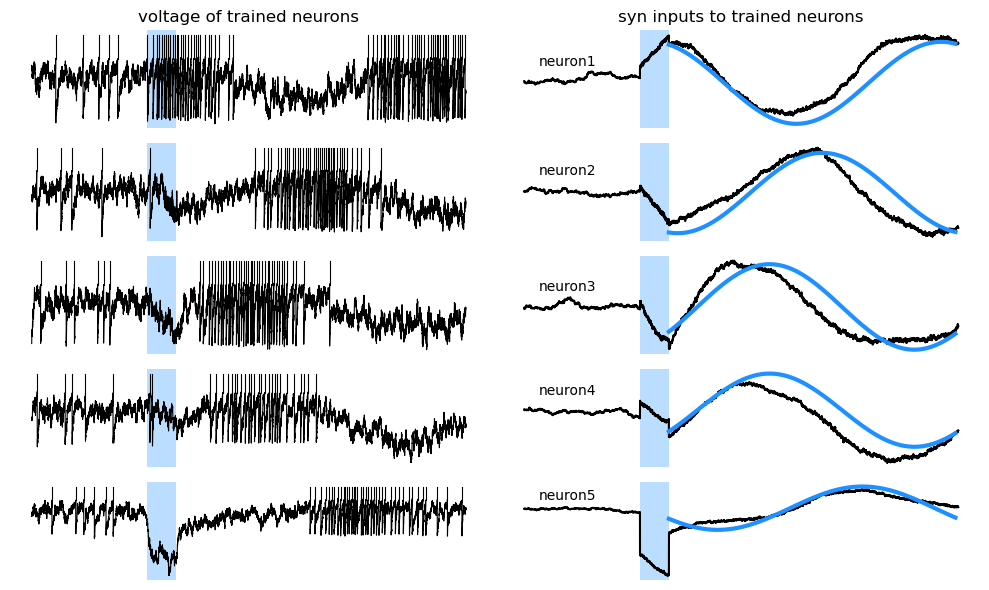

In [107]:
# compare synaptic drive of example neurons and their target activity paterns
tvec = collect(p.dt:p.dt:p.train_time)
ttarg = collect(0:p.learn_every:p.train_duration-p.learn_every) .+ 1000.0
figure(figsize=(10,6))
for ci = 1:5
    subplot(5,2,2*(ci-1)+1)
    axvspan(800, 1000, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, vsave[:,ci], c="k", lw=0.8)
    for t = 1:ns[ci]
        plot([times[ci][t],times[ci][t]],[1,1.4],c="k", lw=0.8)
    end
    if ci ==1
        title("voltage of trained neurons")
    end
    axis("off")

    subplot(5,2,2*ci)
    axvspan(800, 1000, color="dodgerblue", alpha=0.3, ec="None")
    plot(tvec, usave[:,ci], c="k")
    plot(ttarg, xtarg[:,ci], c="dodgerblue", lw=3)
    annotate("neuron$(ci)",(100,usave[50,ci]+0.2), fontsize=10)
    if ci ==1
        title("syn inputs to trained neurons")
    end
    axis("off")
end
tight_layout()
plt.savefig("figure/spiking_generic_trained_neurons.png", dpi=300)
PyPlot.display_figs()